### Prediction des prix de pétroles

#### Objectif commercial
Dans le contexte de l'ensemble de données mondiales sur la production, les prix, les exportations et les exportations nettes de pétrole et de gaz naturel, les données sur la production et les prix du pétrole couvrent la période 1932-2014 (les données de 2014 sont incomplètes) ; la production et les prix du gaz couvrent la période 1955-2014 ; les données sur les exportations et les exportations nettes couvrent la période 1986-2013, nous avons besoin d'analyser les prix historiques et de prédire les prix futurs.

Target : prix du pétrole future


#### Chargement et préparation des données


In [21]:
import os
import sys
sys.path.append(os.path.join('..'))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

In [2]:
train_file = os.path.join('.','Data','train.csv') 
test_file = os.path.join('.','Data','test.csv') 
df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

In [3]:
# Vérification des types et des valeurs manquantes
print(df_train.info())
print(df_train.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10556 entries, 0 to 10555
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    10556 non-null  int64  
 1   cty_name                      10556 non-null  object 
 2   iso3numeric                   10556 non-null  int64  
 3   id                            10556 non-null  object 
 4   year                          10556 non-null  int64  
 5   eiacty                        9911 non-null   object 
 6   oil_prod32_14                 6977 non-null   float64
 7   oil_price_2000                10544 non-null  float64
 8   oil_price_nom                 10556 non-null  float64
 9   oil_value_nom                 6977 non-null   float64
 10  oil_value_2000                6977 non-null   float64
 11  oil_value_2014                6977 non-null   float64
 12  gas_prod55_14                 6080 non-null   float64
 13  g

In [ ]:
# Colonnes d'intérêt
gas_cols = [
    'year', 'cty_name', 'gas_price_nom', 'gas_price_2000', 
    'gas_price_2000_mboe', 'gas_prod55_14', 
    'net_gas_exports_bcf', 'net_gas_exports_mboe'
]

df_gas = df_train[gas_cols].dropna(subset=['year', 'gas_price_nom'])
df_gas = df_gas.sort_values(by='year')

# Conversion des types (au cas où)
df_gas['gas_prod55_14'] = pd.to_numeric(df_gas['gas_prod55_14'], errors='coerce')

,year,cty_name,gas_price_nom,gas_price_2000,gas_price_2000_mboe,gas_prod55_14,net_gas_exports_bcf,net_gas_exports_mboe
5502,1932,Japan,0.060000,NaN,0.000000e+00,NaN,NaN,NaN
3454,1932,Saudi Arabia,0.060000,NaN,0.000000e+00,NaN,NaN,NaN
5463,1932,Vietnam,0.060000,NaN,0.000000e+00,NaN,NaN,NaN
10432,1932,Pakistan,0.060000,NaN,0.000000e+00,NaN,NaN,NaN
10492,1932,Kyrgyz Republic,0.060000,NaN,0.000000e+00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
316,2014,Switzerland,4.347742,3.162515,1.712125e+07,0.0000,NaN,NaN
9932,2014,Saudi Arabia,4.347742,3.162515,1.712125e+07,553.3374,NaN,NaN
8845,2014,Guyana,4.347742,3.162515,1.712125e+07,NaN,NaN,NaN
2557,2014,Mexico,4.347742,3.162515,1.712125e+07,295.6536,NaN,NaN


In [25]:

# Filtrage des colonnes pertinentes pour le pétrole
oil_cols = ['year', 'cty_name', 'oil_price_nom', 'oil_price_2000', 'oil_prod32_14', 'net_oil_exports']
df_oil = df_train[oil_cols].dropna(subset=['year', 'oil_price_nom'])
df_oil = df_oil.sort_values(by='year')
df_oil

,year,cty_name,oil_price_nom,oil_price_2000,oil_prod32_14,net_oil_exports
5502,1932,Japan,0.870000,10.860860,NaN,NaN
3454,1932,Saudi Arabia,0.870000,10.860860,NaN,NaN
5463,1932,Vietnam,0.870000,10.860860,0.000000e+00,NaN
10432,1932,Pakistan,0.870000,10.860860,NaN,NaN
10492,1932,Kyrgyz Republic,0.870000,10.860860,NaN,NaN
...,...,...,...,...,...,...
316,2014,Switzerland,98.946008,71.972588,0.000000e+00,NaN
9932,2014,Saudi Arabia,98.946008,71.972588,4.848201e+08,NaN
8845,2014,Guyana,98.946008,71.972588,0.000000e+00,NaN
2557,2014,Mexico,98.946008,71.972588,1.224613e+08,NaN


#### Description des données

In [26]:
df_train.head()
# Que faire des données manquantes ? 

,Unnamed: 0,cty_name,iso3numeric,id,year,eiacty,oil_prod32_14,oil_price_2000,oil_price_nom,oil_value_nom,...,net_gas_exports_mboe,net_gas_exports_value,net_gas_exports_valuePOP,net_oil_gas_exports_valuePOP,population,pop_maddison,sovereign,mult_nom_2000,mult_nom_2014,mult_2000_2014
0,1,Thailand,764,THA,1957,Thailand,NaN,11.476280,1.900000,NaN,...,NaN,NaN,NaN,NaN,25041917.0,25041917.0,1,6.111378,8.401761,1.374774
1,2,Thailand,764,THA,1984,Thailand,788000.0,45.818440,28.780000,1.662344e+08,...,NaN,NaN,NaN,NaN,49769891.0,50533778.0,1,1.657363,2.278499,1.374774
2,3,Slovak Republic,703,SVK,2014,Slovakia,9960.0,71.972588,98.946008,7.223731e+06,...,NaN,NaN,NaN,NaN,5418506.0,NaN,1,0.727393,1.000000,1.374774
3,4,Moldova,498,MDA,1967,Moldova,NaN,9.161955,1.800000,NaN,...,NaN,NaN,NaN,NaN,3452263.0,3452263.0,0,5.153946,7.085508,1.374774
4,5,Vietnam,704,VNM,1996,Vietnam,8850000.0,22.484490,20.668488,1.340775e+09,...,0.0,0.0,0.0,18.589735,74360136.0,74941175.0,1,1.097514,1.508834,1.374774



city_name

Noms des pays dont les données ont été extraites.

iso3numeric

Codes de pays numériques à trois chiffres définis dans l'ISO 3166-1, partie de la norme ISO 3166 publiée par l'Organisation internationale de normalisation (ISO), pour représenter les pays, les territoires dépendants et les zones spéciales d'intérêt géographique. Afghanistan- 004.

id

Même chose que iso3numeric.

Year

Données collectées pour l'année.

eiacity

Nom du pays de l'Energy Information Administration.

oil_prod32_14

Production de pétrole de 1932 à 2014. Données converties de barils en tonnes métriques.

oil_price_2000

Prix nominal du pétrole de chaque année déflaté du prix du pétrole de l'année 2000.

oil_price_nom

dollars américains par baril pour les années respectives.

oil_value_nom

Obtenu en multipliant la production de pétrole et le prix nominal du pétrole pour les années respectives : Le prix nominal du pétrole en Argentine pour l'année était de 0,87 et 1794945 tonnes métriques de pétrole ont été produites. 1Tonne métrique = 7,33 barils Pour 13156946,85 barils, la valeur est 11446543,7595.

oil_value_2000

Production de pétrole (barils) multipliée par le prix nominal multiplié par le multiplicateur d'inflation (mult_nom_2000) pour les années respectives. Exemple : Inde en 1932 8829043.64* 0.87* 12.599874 = 96783008.5419

oil_value_2014

Production de pétrole (barils) multipliée par le prix nominal multiplié par le multiplicateur d'inflation (mult_nom_2014) pour les années respectives. Exemple : Australie en 1948 1004,21* 9,82691136* 1,99 = 19637,8824871

gas_prod55_14

Production de gaz de 1955 à 2014.

gas_price_2000_mboe

Prix du gaz en millions de barils équivalent pétrole en 2000. Le pétrole est mesuré en barils et le gaz naturel en pieds cubes. Pour faciliter les comparaisons, l'industrie a normalisé la production de gaz naturel en « équivalents barils » de pétrole.

gas_price_2000

Prix du gaz en 2000

gas_price_nom

Prix du gaz pour les années respectives.

gas_value_nom

Valeur du pétrole en multipliant la production de pétrole et le prix nominal du pétrole pour les années respectives.

gas_value_2000

Valeur du gaz en 2000.

gas_value_2014

La valeur du gaz en 2014 tient compte de l'inflation.

oil_gas_value_nom

Valeur du gaz et du pétrole produits pour les années respectives. Exemple : La valeur du gaz pour l'Albanie en 1934 est de 10012,78 et la valeur du gaz est de 0 (on suppose que c'est zéro car les données sont vides). Valeur totale du pétrole = 10012,78+0 = 10012,78

oil_gas_value_2000

Valeur du gaz et du pétrole en 2000, corrigée de l'inflation.

oil_gas_value_2014

Valeur du pétrole et du gaz en 2014.

oil_gas_valuePOP_nom

Il s'agit du revenu pétrolier par habitant, qui mesure la valeur annuelle, en termes réels, de la production de pétrole et de gaz naturel d'un pays, divisée par sa population. Exemple : Pour l'Albanie en 1934, la valeur du pétrole par habitant est la suivante valeur du pétrole par habitant/population = 10012,78/1003000 = 0,009983.

oil_gas_valuePOP_2000

Même chose que oil_gas_valuePOP_nom.

oil_gas_valuePOP_2014

Même chose que oil_gas_valuePOP_nom.

oil_exports

Données sur les exportations de pétrole des pays pour les années respectives. Les exportations nettes sont calculées en soustrayant les importations.

net_oil_exports

Les exportations nettes de pétrole sont la valeur des exportations totales de pétrole d'un pays moins la valeur de ses importations totales de pétrole. Les valeurs négatives indiquent que les exportations sont inférieures aux importations, ce qui crée une balance commerciale négative.

net_oil_exports_mt

Exportations nettes de pétrole en tonnes métriques par an.

net_oil_exports_value

Valeur des exportations nettes de pétrole produites au cours de l'année concernée.

net_oil_exports_valuePOP

Valeur des exportations nettes de pétrole par habitant, Valeur des exportations nettes de pétrole d'un pays divisée par sa population.

gas_exports

Exportations de gaz pour les pays pour les années respectives en tonnes métriques par an.

net_gas_exports_bcf

Exportations nettes de gaz en milliards de pieds cubes par jour.

net_gas_exports_mboe

Exportations nettes de gaz en millions de barils équivalent pétrole.

net_gas_exports_value

Valeur totale des exportations nettes de gaz par pays pour les années respectives.

net_gas_exports_valuePOP

Valeur des exportations nettes de gaz par habitant, Valeur des exportations nettes de gaz des exportations de pétrole d'un pays divisée par sa population.

net_oil_gas_exports_valuePOP

Valeur des exportations nettes de pétrole et de gaz par habitant, Valeur des exportations nettes de pétrole et de gaz d'un pays divisée par sa population.

population

Les données sur la population sont tirées des indicateurs de développement mondial de la Banque mondiale.

pop_maddison

Les données sur la population sont tirées de la base de données d'Angus Maddison pour les années antérieures à 1950.

sovereign

Des données ont été collectées pour les pays avant qu'ils ne deviennent souverains. Indiqué par une variable binaire. 0- Non souverain et 1- souverain.

mult_nom_2000

Multiplicateur d'inflation pour passer de la valeur nominale à la valeur constante de 2000 en dollars américains.

mult_nom_2014

Multiplicateur d'inflation pour convertir la valeur nominale en valeur constante pour 2014 en dollars américains.

mult_2000_2014

Multiplicateur d'inflation pour convertir les valeurs nominales en valeurs constantes de 2000 et de 2014 en dollars américains.

#### Analyse des tendances historiques des prix du pétrole et du gaz 

##### Analyse exploratoire visuelle des prix

In [31]:
fig = px.line(
    df_gas,
    x="year",
    y=["gas_price_nom", "gas_price_2000"],
    labels={"value": "Prix du gaz (USD par unité)", "variable": "Type de prix"},
    title="Évolution des prix du gaz naturel (nominal vs ajusté à 2000)"
)
fig.show()

In [ ]:
# Prix nominal vs. ajusté (réel)
fig = px.scatter(
    df_oil,
    x="year",
    y=["oil_price_nom", "oil_price_2000"],
    labels={"value": "Prix du pétrole (USD/baril)", "variable": "Type de prix"},
    title="Évolution des prix du pétrole (nominal vs. ajusté à l'année 2000)"
)
fig.show()


##### Identifier les périodes de volatilité (rolling std)

In [34]:
df_gas['rolling_std_nom'] = df_gas['gas_price_nom'].rolling(window=5).std()
df_gas['rolling_std_2000'] = df_gas['gas_price_2000'].rolling(window=5).std()

fig2 = px.scatter(
    df_gas,
    x='year',
    y=['rolling_std_nom', 'rolling_std_2000'],
    title="Volatilité glissante (5 ans) des prix du gaz naturel",
    labels={'value': 'Écart-type glissant', 'variable': 'Type de prix'}
)
fig2.show()


In [35]:
# Calcul de l'écart-type glissant sur 5 ans
df_oil = df_oil.sort_values(by="year")
df_oil['rolling_std_nom'] = df_oil['oil_price_nom'].rolling(window=5).std()
df_oil['rolling_std_2000'] = df_oil['oil_price_2000'].rolling(window=5).std()

# Visualisation
fig2 = px.line(
    df_oil,
    x='year',
    y=['rolling_std_nom', 'rolling_std_2000'],
    title="Volatilité glissante (5 ans) des prix du pétrole",
    labels={'value': 'Écart-type glissant', 'variable': 'Type de prix'}
)
fig2.show()


##### Relations entre production, prix et exportations

In [41]:
# Matrice de corrélation
corr = df_oil[['oil_price_nom', 'oil_prod32_14', 'net_oil_exports']].corr()

# Heatmap avec annotations visibles
fig_corr = go.Figure(data=go.Heatmap(
    z=corr.values,
    x=corr.columns,
    y=corr.index,
    colorscale='RdBu',
    zmin=-1, zmax=1,
    text=np.round(corr.values, 2),
    texttemplate="%{text}",
    colorbar=dict(title="Corrélation")
))

fig_corr.update_layout(
    title="Corrélation entre production, prix et exportations nettes de pétrole",
    xaxis_title="Variables",
    yaxis_title="Variables"
)

fig_corr.show()



In [42]:
# Matrice de corrélation
corr_gas = df_gas[['gas_price_nom', 'gas_prod55_14', 'net_gas_exports_mboe']].corr()

fig_corr = go.Figure(data=go.Heatmap(
    z=corr_gas.values,
    x=corr_gas.columns,
    y=corr_gas.index,
    colorscale='Viridis',
    zmin=-1,
    zmax=1,
    text=corr_gas.round(2).values,
    texttemplate="%{text}",  # Affiche les valeurs directement sur la heatmap
    colorbar=dict(title="Corrélation")
))

fig_corr.update_layout(
    title="Corrélation entre production, prix et exportations nettes de gaz",
    xaxis_title="Variables",
    yaxis_title="Variables"
)

fig_corr.show()


##### Prédiction des prix futurs

In [48]:
df_test

,Unnamed: 0,cty_name,iso3numeric,id,year,eiacty,oil_prod32_14,oil_price_2000,oil_value_nom,oil_value_2000,...,net_gas_exports_mboe,net_gas_exports_value,net_gas_exports_valuePOP,net_oil_gas_exports_valuePOP,population,pop_maddison,sovereign,mult_nom_2000,mult_nom_2014,mult_2000_2014
0,1,Syrian Arab Republic,760,SYR,2001,Syria,2.410000e+07,23.69800,4.318125e+09,4.198651e+09,...,0.000000,0.000000e+00,0.000000,125.783354,17242823.0,16728808.0,1,0.972332,1.336736,1.374774
1,2,United Kingdom,826,GBR,1941,United Kingdom,3.046400e+04,13.17518,2.545633e+05,2.975574e+06,...,NaN,NaN,NaN,NaN,48216000.0,48216000.0,1,11.688936,16.069640,1.374774
2,3,Philippines,608,PHL,1989,Philippines,2.670000e+05,24.86816,3.567051e+07,4.953598e+07,...,NaN,NaN,NaN,NaN,59702444.0,63554672.0,1,1.388710,1.909161,1.374774
3,4,Kyrgyz Republic,417,KGZ,1944,Kyrgyzstan,NaN,11.71031,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,9.780960,13.446605,1.374774
4,5,Cape Verde,132,CPV,1988,Cape Verde,0.000000e+00,21.41834,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,336065.0,336065.0,1,1.455621,2.001150,1.374774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4960,4961,Yemen Arab Rep. (North Yemen),886,NaN,1961,NaN,0.000000e+00,10.23677,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,5993828.0,5993828.0,0,5.751480,7.906982,1.374774
4961,4962,Bulgaria,100,BGR,1986,Bulgaria,9.300000e+04,22.21579,9.836787e+06,1.545524e+07,...,NaN,NaN,NaN,NaN,8933715.0,8958770.0,1,1.571168,2.160000,1.374774
4962,4963,Yemen Arab Rep. (North Yemen),886,NaN,1995,NaN,NaN,19.09535,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1.129921,1.553386,1.374774
4963,4964,Serbia,688,SRB,1987,NaN,NaN,27.45986,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1.515845,2.083944,1.374774


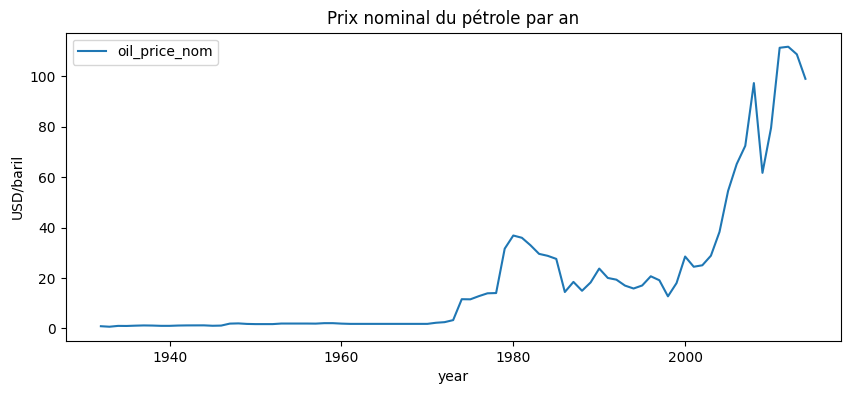

In [49]:
# On prend uniquement les prix du pétrole par année
df_oil_train = df_train[['year', 'oil_price_nom']].dropna().groupby('year').mean().reset_index()
df_oil_test = df_test[['year']].dropna().groupby('year').mean().reset_index()

# Index temporel
df_oil_train.set_index('year', inplace=True)
df_oil_test.set_index('year', inplace=True)

df_oil_train.plot(title="Prix nominal du pétrole par an", figsize=(10,4))
plt.ylabel("USD/baril")
plt.show()



#### Évaluation
La mesure d'évaluation utilisée dans ce concours est le RMSE (Root Mean Squared Error).